<a href="https://colab.research.google.com/github/S1998raghu/S1998raghu2.github.io/blob/main/dataPreprocessingNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io



In [ ]:
from google.colab import drive
import os

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Specify the path of the ZIP file and the target directory
zip_file_path = '/content/drive/My Drive/Colab Notebooks/data/data.zip'
target_dir = '/content/drive/My Drive/Colab Notebooks/data1'

# Step 3: Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Step 4: Unzip the file
!unzip "{zip_file_path}" -d "{target_dir}"


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/Colab Notebooks/data1/data/ESP_020415_1195_15360_20480_5120_10240/tiles/frost/ESP_020415_1195_16257_16556_8708_9007.png  
  inflating: /content/drive/My Drive/Colab Notebooks/data1/data/ESP_020415_1195_15360_20480_5120_10240/tiles/frost/ESP_020415_1195_16556_16855_6914_7213.png  
  inflating: /content/drive/My Drive/Colab Notebooks/data1/data/ESP_020415_1195_15360_20480_5120_10240/tiles/frost/ESP_020415_1195_16257_16556_6914_7213.png  
  inflating: /content/drive/My Drive/Colab Notebooks/data1/data/ESP_020415_1195_15360_20480_5120_10240/tiles/frost/ESP_020415_1195_16556_16855_8708_9007.png  
  inflating: /content/drive/My Drive/Colab Notebooks/data1/data/ESP_020415_1195_15360_20480_5120_10240/tiles/frost/ESP_020415_1195_18948_19247_8110_8409.png  
  inflating: /content/drive/My Drive/Colab Notebooks/data1/data/ESP_020415_1195_15360_20480_5120_10240/tiles/frost/ESP_020415_1195_18350_18649_9605_9904.p

# New Section

In [8]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('/content/drive/My Drive/Colab Notebooks/data1/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

src_image_ids

['ESP_026602_1300',
 'ESP_072193_1845',
 'ESP_020415_1195',
 'ESP_067228_1820',
 'ESP_049512_1310',
 'ESP_070763_1790',
 'ESP_047596_1845',
 'ESP_019459_2185',
 'ESP_045865_1825',
 'ESP_026602_1300',
 'ESP_018828_2445',
 'ESP_070763_1790',
 'ESP_018828_2445',
 'ESP_011605_1170',
 'PSP_002904_1255',
 'ESP_066813_2360',
 'PSP_008120_2465',
 'ESP_020415_1195',
 'ESP_035667_2295',
 'ESP_040959_1355',
 'ESP_073664_1205',
 'ESP_072569_1320',
 'ESP_018002_1820',
 'ESP_019781_1300',
 'ESP_042279_1820',
 'ESP_026885_2295',
 'PSP_005315_1770',
 'ESP_040959_1355',
 'ESP_045865_1825',
 'PSP_006825_2465',
 'ESP_067228_1820',
 'ESP_068434_2450',
 'ESP_016518_2535',
 'ESP_048733_2075',
 'PSP_005315_1770',
 'ESP_072193_1845',
 'ESP_067228_1820',
 'ESP_039175_1200',
 'PSP_008120_2465',
 'ESP_053223_1770',
 'ESP_019781_1300',
 'ESP_038058_1205',
 'ESP_047596_1845',
 'ESP_055340_1185',
 'ESP_018828_2445',
 'ESP_072193_1845',
 'ESP_032207_1350',
 'PSP_002033_1325',
 'ESP_066813_2360',
 'ESP_018002_1820',


In [9]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/My Drive/Colab Notebooks/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/My Drive/Colab Notebooks/val_source_images.txt')
test_ids = load_text_ids('/content/drive/My Drive/Colab Notebooks/test_source_images.txt')

validate_ids
train_ids
test_ids



['ESP_016518_2535',
 'ESP_017506_2450',
 'ESP_017717_2450',
 'ESP_019207_2450',
 'ESP_026602_1300',
 'ESP_026885_2295',
 'ESP_028501_1295',
 'ESP_035667_2295',
 'ESP_047596_1845',
 'ESP_055340_1185',
 'ESP_066956_2450',
 'ESP_067022_2450',
 'ESP_067517_1430',
 'ESP_068038_2450',
 'ESP_068434_2450',
 'ESP_070763_1790',
 'ESP_072796_1295',
 'PSP_006825_2465']

In [10]:
# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)
subdir_splits

['test',
 'train',
 'train',
 'train',
 'validate',
 'test',
 'test',
 'train',
 'train',
 'test',
 'train',
 'test',
 'train',
 'validate',
 'train',
 'validate',
 'train',
 'train',
 'test',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'test',
 'validate',
 'train',
 'train',
 'test',
 'train',
 'test',
 'test',
 'validate',
 'validate',
 'train',
 'train',
 'train',
 'train',
 'validate',
 'train',
 'train',
 'test',
 'test',
 'train',
 'train',
 'validate',
 'train',
 'validate',
 'train',
 'train',
 'validate',
 'train',
 'train',
 'train',
 'validate',
 'train',
 'train',
 'validate',
 'test',
 'train',
 'test',
 'train',
 'train',
 'train',
 'test',
 'train',
 'validate',
 'test',
 'train',
 'validate',
 'train',
 'validate',
 'test',
 'train',
 'test',
 'train',
 'test',
 'validate',
 'test',
 'validate',
 'train',
 'validate',
 'train',
 'validate',
 'validate',
 'train',
 'test',
 'train',
 'train',
 'test',
 'train',
 'train',
 'train',
 'test',
 'train',
 'v

In [11]:
import random
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image
def load_and_preprocess(img_loc, label):


  def _inner_function(img_loc, label):

    img_loc_str = img_loc.numpy().decode('utf-8')
# Load image using PIL and convert to RGB
    img = Image.open(img_loc_str).convert('RGB')

 # Convert PIL image to numpy array
    img = np.array(img)
    img = tf.image.resize(img, [299, 299])

 # Normalize the image to the [0, 1] range
    img = img / 255.0

# Convert label to integer (assuming binary classification)
    label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
    return img, label

# Wrap the Python function
  X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

 # Set the shape of the tensors
  X.set_shape([299, 299, 3])
  y.set_shape([]) # Scalar label

  return X, y




In [12]:
def load_and_preprocess_train(img_loc, label):
    # Load and decode the image
    img = tf.io.read_file(img_loc)
    img = tf.io.decode_png(img, channels=3)

    # Cropping
    img = tf.image.random_crop(img, size=[250, 250, 3])  # Adjust the size as needed

    # Random Zoom (resize back to original size after cropping)
    img = tf.image.resize(img, [299, 299])

    # Random Rotation
    img = tf.image.rot90(img, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random Flip (Horizontal)
    img = tf.image.random_flip_left_right(img)

    # Random Contrast Adjustment
    img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
    img = img / 255.0
    # Random Translation
    img = tf.image.pad_to_bounding_box(img, offset_height=10, offset_width=10, target_height=310, target_width=310)
    img = tf.image.random_crop(img, size=[299, 299, 3])

    # Convert label to a tensor
    label = tf.where(tf.equal(label, 'frost'), 1, 0)

    return img, label


In [13]:


def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 16

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)


tf_dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
# Extract one batch from the training dataset
for images, labels in tf_dataset_train.take(1):
    # Print the shape of images and labels
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)


Image batch shape: (16, 299, 299, 3)
Label batch shape: (16,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Model definition
model = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(299, 299, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(
    tf_dataset_train,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plotting code for training and validation errors vs. epochs is not included


Epoch 1/20
883/883 [==============================] - 371s 400ms/step - loss: 46.4524 - accuracy: 0.6894 - val_loss: 2964.8384 - val_accuracy: 0.2310
Epoch 2/20
883/883 [==============================] - 354s 400ms/step - loss: 24.1914 - accuracy: 0.6452 - val_loss: 15.9714 - val_accuracy: 0.8672
Epoch 3/20
883/883 [==============================] - 351s 398ms/step - loss: 10.4844 - accuracy: 0.6426 - val_loss: 21.9815 - val_accuracy: 0.2735
Epoch 4/20
883/883 [==============================] - 371s 420ms/step - loss: 5.5571 - accuracy: 0.6508 - val_loss: 6.4099 - val_accuracy: 0.3334
Epoch 5/20
883/883 [==============================] - 370s 419ms/step - loss: 12.5095 - accuracy: 0.6529 - val_loss: 11.8082 - val_accuracy: 0.5747
Epoch 6/20
883/883 [==============================] - 369s 418ms/step - loss: 6.9895 - accuracy: 0.6469 - val_loss: 4.8304 - val_accuracy: 0.2331
Epoch 7/20
883/883 [==============================] - 370s 418ms/step - loss: 6.1996 - accuracy: 0.6462 - val_loss

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/saved_model.h5'
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
import tensorflow as tf


def get_or_create_model():
    try:
        # Try to load the model
        model_path = '/content/drive/My Drive/Colab Notebooks/saved_model.h5'
        model = tf.keras.models.load_model(model_path)
        print("Loaded saved model from:", model_path)
    except IOError:
        # If model does not exist, create a new one
        model = create_model()
        print("No saved model found. Created a new model.")
    return model

model = get_or_create_model()

Loaded saved model from: /content/drive/My Drive/Colab Notebooks/saved_model.h5


In [15]:
train_model = False  # Set this to False if you want to skip training

if train_model:
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(
        tf_dataset_train,
        epochs=20,
        validation_data=tf_dataset_val,
        callbacks=[early_stopping]
    )
    model.save(model_path)
    print("Model saved to:", model_path)
else:
    print("Using the loaded model without retraining.")

Using the loaded model without retraining.


In [ ]:
test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print("Test Loss:", test_loss)
print("Test Accuracy:",test_accuracy)

 12/883 [..............................] - ETA: 25:43 - loss: 3.1112 - accuracy: 0.5990

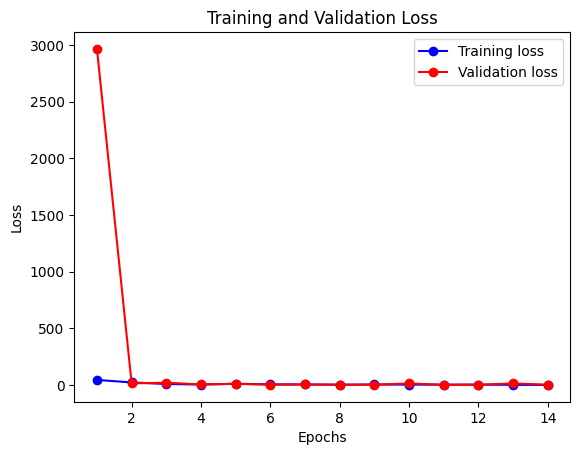

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an epoch array (1, 2, 3, ..., number of epochs)
epochs = range(1, len(train_loss) + 1)

# Plotting
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Assuming tf_dataset_test is a TensorFlow dataset
# And each element is a tuple (input, label)

true_labels = []
for _, label in tf_dataset_test:
    true_labels.extend(label.numpy())

# true_labels is now a list of the actual labels


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict probabilities on the test set
probabilities = model.predict(tf_dataset_test)
# Convert probabilities to class labels
predictions = np.argmax(probabilities, axis=1)

# Assuming you have the true labels in a variable `true_labels`
# true_labels should be a 1D array with the same length as predictions
# For example: true_labels = np.array([...])

precision = precision_score(true_labels, predictions, average='binary')
recall = recall_score(true_labels, predictions, average='binary')
f1 = f1_score(true_labels, predictions, average='binary')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


883/883 [==============================] - 121s 137ms/step
Precision: 0.6506834761668674
Recall: 1.0
F1 Score: 0.7883806745044195


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Load pre-trained EfficientNetB0 model without top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))


16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
# Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)  # New FC layer
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)
  # New softmax layer for binary classification

# Define the new model
model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the same training data
history = model.fit(
    tf_dataset_train,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping]
)
# Evaluate the model
test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


NameError: ignored

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/saved_model_efficientnet.h5'
model.save(model_path)

NameError: ignored

In [2]:
from google.colab import drive
import os

# Step 1: Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive
